# Libraries

In [1]:
from fastai.vision.all import *

# check data

In [2]:
import os
from pathlib import Path

path = Path(r'/home/tempestade/Área de Trabalho/git/geoeyeai/cell_data')
train_path = path / 'trainn'
masks_path = path / 'masks'

print(f"📊 VERIFICADOR FINAL: {path}")
print("-" * 50)

imagens = [f for f in train_path.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
mascaras_arquivos = [f.name for f in masks_path.iterdir()]

print(f"📸 Imagens: {len(imagens)}")
print(f"🎭 Máscaras: {len(mascaras_arquivos)}")
print("-" * 50)

erros = 0
sucessos = 0

print("🔍 Verificando...")

for img in imagens:
    # A REGRA CORRETA AGORA:
    # Pega o nome do arquivo (stem) e só adiciona .png
    nome_esperado_mascara = img.stem + '.png'
    
    if nome_esperado_mascara in mascaras_arquivos:
        sucessos += 1
    else:
        erros += 1
        print(f"❌ ERRO: {img.name}")

print("-" * 50)
if erros == 0:
    print(f"✅ SUCESSO ABSOLUTO! {sucessos} pares encontrados.")
    print("🚀 Pode iniciar o treinamento sem medo.")
else:
    print(f"⚠️ Ainda temos {erros} erros.")

📊 VERIFICADOR FINAL: /home/tempestade/Área de Trabalho/git/geoeyeai/cell_data
--------------------------------------------------
📸 Imagens: 1533
🎭 Máscaras: 1533
--------------------------------------------------
🔍 Verificando...
--------------------------------------------------
✅ SUCESSO ABSOLUTO! 1533 pares encontrados.
🚀 Pode iniciar o treinamento sem medo.


# GPU

In [3]:
import numpy as np
from fastai.vision.all import *
from pathlib import Path
import PIL
import torch # Importante para checar a GPU

# ==============================================================================
# 0. CHECK-UP DE GPU (NOVO BLOCO) 🚀
# ==============================================================================
print("🔍 Verificando Hardware...")
devide = 'cpu'
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ SUCESSO! GPU Detectada: {gpu_name}")
    print(f"🧠 Memória de Vídeo (VRAM): {vram:.2f} GB")
    
    # Força o FastAI a usar a GPU 0 (caso tenha mais de uma)
    torch.cuda.set_device(0)
    device = 'cuda'
else:
    print("⚠️ PERIGO: Nenhuma GPU detectada!")
    print("🐢 O treino rodará na CPU (Processador) e será EXTREMAMENTE LENTO.")
    print("   Verifique se instalou a versão do PyTorch com suporte a CUDA.")

print("-" * 50)

🔍 Verificando Hardware...
✅ SUCESSO! GPU Detectada: NVIDIA GeForce RTX 4070
🧠 Memória de Vídeo (VRAM): 12.59 GB
--------------------------------------------------


# Run model

import numpy as np
from fastai.vision.all import *
from pathlib import Path
import PIL
import torch

# ==============================================================================
# 1. CONFIGURAÇÃO
# ==============================================================================
# Ajuste o caminho se necessário
path = Path(r'/home/tempestade/Área de Trabalho/git/geoeyeai/cell_data')

# Mapeamento: Valor na Imagem -> ID da Classe
pixel_map = {
    82:  1,  # Agua
    222: 2,  # Erosao
}

# Nomes das classes
meus_codes = ['Background', 'Agua', 'Erosao']

# ==============================================================================
# 2. FUNÇÕES
# ==============================================================================
def mask_converter(arquivo_da_mascara):
    # Cria uma máscara vazia se o arquivo não existir
    if not Path(arquivo_da_mascara).exists():
        # Retorna 512x512 vazio (ajuste o tamanho se suas imagens forem diferentes)
        return PILMask.create(np.zeros((512,512), dtype=np.uint8))

    mask = PILMask.create(arquivo_da_mascara)
    mask_np = np.array(mask)
    new_mask = np.zeros_like(mask_np, dtype=np.uint8)
    
    for cor_original, novo_id in pixel_map.items():
        # Tolerância de +/- 5
        match = (mask_np >= cor_original - 5) & (mask_np <= cor_original + 5)
        new_mask[match] = novo_id
        
    return PILMask.create(new_mask)

def get_y_fn(x):
    # Ajuste aqui se a estrutura de pastas for diferente
    # Exemplo: Se x é ".../images/img1.png", as máscaras estão em ".../masks/img1.png"
    folder_masks = x.parent.parent / 'masks'
    nome_arquivo = x.stem + '.png'
    path_final = folder_masks / nome_arquivo
    return mask_converter(str(path_final))

# ==============================================================================
# 3. MÉTRICAS
# ==============================================================================
def pixel_accuracy(inp, targ):
    targ = targ.squeeze(1) 
    return (inp.argmax(dim=1) == targ).float().mean()

# ==============================================================================
# 4. TREINAMENTO
# ==============================================================================
# DataBlock
dblock = DataBlock(
                    blocks=(ImageBlock, MaskBlock(codes=meus_codes)),
                    get_items=get_image_files, 
                    get_y=get_y_fn,            
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    item_tfms=[Resize(512)],   
                    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                )

print("⏳ Carregando dados...")

# ATENÇÃO AO NOME DA PASTA: 'trainn' ou 'train'?
# bs=4 é mais seguro para 512px, mas bs=8 pode rodar na 4070
dls = dblock.dataloaders(path / 'trainn', bs=4, num_workers=0)

# Mostra um lote para garantir que as máscaras estão alinhadas
dls.show_batch(max_n=4)

# Define métricas
metrics = [Dice(), pixel_accuracy]

print("🧠 Criando modelo (Sem pré-treino)...")
# pretrained=False: Cria o modelo do zero (Resolve seu problema de internet)
save_best = SaveModelCallback(monitor='dice', comp=np.greater, fname='melhor_modelo')
early_stop = EarlyStoppingCallback(monitor='dice', comp=np.greater, min_delta=0.001, patience=3)
learn = unet_learner(dls, resnet34, metrics=metrics, pretrained=False).to_fp16()

print("🚀 Começando o treino...")

# fit_one_cycle é OBRIGATÓRIO quando pretrained=False
# fine_tune só serve para modelos baixados da internet
learn.fit_one_cycle(30, lr_max=1e-3, cbs=[save_best, early_stop])

# Mostra resultado
learn.show_results(max_n=4, figsize=(10,10))

In [4]:
import os
import torch
import gc

# 1. Configuração de Fragmentação (Ajuda muito a RTX 4070)
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# 2. Forçar limpeza (mesmo após restart é bom ter no código)
gc.collect()
torch.cuda.empty_cache()

⏳ Carregando dados 512x512...


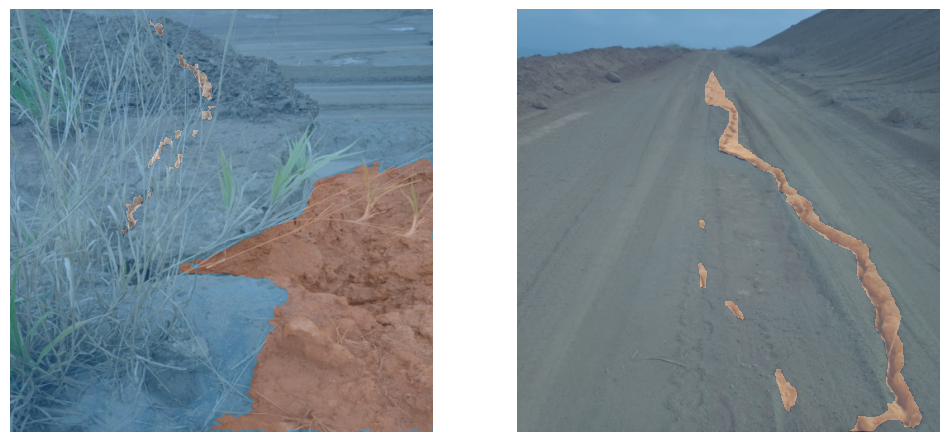

In [5]:
import numpy as np
from fastai.vision.all import *
from pathlib import Path
import PIL
import torch

# ==============================================================================
# 1. CONFIGURAÇÕES GERAIS E CAMINHOS
# ==============================================================================
# Caminho base do dataset
path = Path(r'/home/tempestade/Área de Trabalho/git/geoeyeai/cell_data')

# Tamanho da Imagem para o Paper (Alta Resolução)
TAMANHO_IMG = 512 
MODEL_NAME = 'resnet50'  # Opções: vgg16_bn, vgg19_bn, resnet18, resnet34, resnet50, efficientnet_b3, densenet121, mobilenet_v2
# 2. Dicionário de mapeamento
model_map = {
    'vgg16_bn': vgg16_bn,
    'vgg19_bn': vgg19_bn,
    'resnet18': resnet18,
    'resnet34': resnet34,
    'resnet50': resnet50,
    'efficientnet_b3': efficientnet_b3,
    'densenet121': densenet121,
    'mobilenet_v2': mobilenet_v2
}
export_name = f'modelo_{MODEL_NAME}_final_{TAMANHO_IMG}'

# Mapeamento: (R, G, B) -> ID da Classe
# 0 = Background (Preto) é automático
pixel_map = {
                        (61, 61, 245): 1,
                        (221, 255, 51): 2,
                        (252, 128, 7): 3,
                        (36, 179, 83): 4
                    }

# Nomes das classes para os gráficos
meus_codes = ['Background', 'Agua', 'Erosao', 'Trinca', 'Ruptura']

# ==============================================================================
# 2. FUNÇÕES DE PROCESSAMENTO DE MÁSCARA
# ==============================================================================
def mask_converter(arquivo_da_mascara):
    # # 1. Proteção contra arquivos inexistentes
    # if not Path(arquivo_da_mascara).exists():
    #     # Retorna máscara preta (Background)
    #     return PILMask.create(np.zeros((1024, 1024), dtype=np.uint8))

    # 2. Abre a imagem mantendo o padrão RGB
    mask = PILImage.create(arquivo_da_mascara) 
    mask_np = np.array(mask)
    
    # 3. Cria uma matriz vazia (preenchida com 0 - Background)
    # Note que ela é 2D agora (Altura, Largura), sem o 3 do RGB
    new_mask = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.uint8)
    
    # 4. Loop Mágico: Procura cada cor e pinta o ID correspondente
    for cor_rgb, novo_id in pixel_map.items():
        # Transforma a tupla (R,G,B) em array numpy
        cor_alvo = np.array(cor_rgb)
        
        # Calcula a diferença absoluta entre a imagem e a cor alvo
        diferenca = np.abs(mask_np - cor_alvo)
        
        # Se a diferença for pequena em todos os canais (R, G e B < 20), é um match!
        # Usamos < 20 de tolerância para ignorar "sujeira" de compressão JPG/PNG
        match = np.all(diferenca < 20, axis=-1)
        
        # Aplica o ID na nova máscara onde deu match
        new_mask[match] = novo_id
        
    return PILMask.create(new_mask)

def get_y_fn(x):
    """Retorna o caminho da máscara correspondente à imagem X"""
    folder_masks = x.parent.parent / 'masks'
    nome_arquivo = x.stem + '.png'
    path_final = folder_masks / nome_arquivo
    return mask_converter(str(path_final))

# ==============================================================================
# 3. MÉTRICAS (PADRÃO PARA ARTIGOS)
# ==============================================================================
def pixel_accuracy(inp, targ):
    # Acurácia simples pixel a pixel
    targ = targ.squeeze(1) 
    return (inp.argmax(dim=1) == targ).float().mean()

# ==============================================================================
# 4. PREPARAÇÃO DOS DADOS (DATALOADERS)
# ==============================================================================
dblock = DataBlock(
                        blocks=(ImageBlock, MaskBlock(codes=meus_codes)),
                        get_items=get_image_files, 
                        get_y=get_y_fn,            
                        splitter=RandomSplitter(valid_pct=0.3, seed=42),
                        item_tfms=[Resize(TAMANHO_IMG, method='squish', resamples=(PIL.Image.BILINEAR, PIL.Image.NEAREST))],
                        batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                    )


print(f"⏳ Carregando dados {TAMANHO_IMG}x{TAMANHO_IMG}...")
# Batch Size (bs=2) é o recomendado para 1024px em 12GB de VRAM.
# num_workers=0 evita estouro de RAM do sistema no carregamento.
dls = dblock.dataloaders(path / 'trainn', bs=2, num_workers=0)

# Mostra um lote de exemplo
dls.show_batch(max_n=4, vmin=0, vmax=4, figsize=(12, 12))

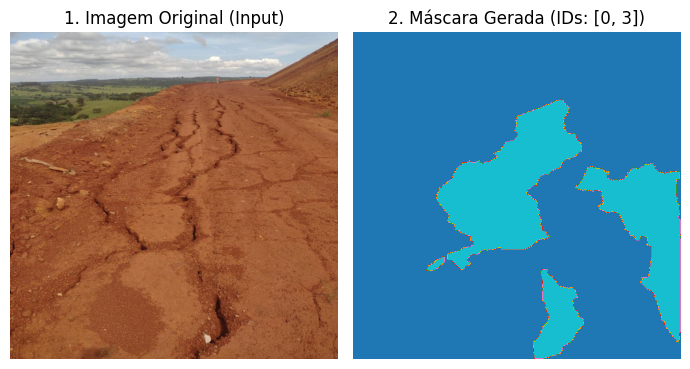

In [6]:
import matplotlib.pyplot as plt

# 1. Pega um exemplo do seu dataset (o índice 0, por exemplo)
# x é a imagem original, y é a máscara processada
x, y = dls.valid_ds[np.random.randint(0, len(dls.valid_ds))]  # Pega um exemplo aleatório da validação

# 2. Cria a figura com duas colunas
fig, ax = plt.subplots(1, 2, figsize=(7, 7))

# Plotar Imagem Real
ax[0].imshow(x)
ax[0].set_title("1. Imagem Original (Input)")
ax[0].axis('off')

# Plotar Máscara Gerada
# Usamos o cmap 'tab10' para que cada ID (0, 1, 2, 3, 4) tenha uma cor bem distinta
ax[1].imshow(tensor(y), cmap='tab10') 
ax[1].set_title(f"2. Máscara Gerada (IDs: {torch.unique(tensor(y)).tolist()})")
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# ==============================================================================
# 5. TREINAMENTO DO MODELO
# ==============================================================================
# Lista de métricas: Acurácia, Dice (F1) e Jaccard (IoU)
metrics = [pixel_accuracy, Dice(axis=1), JaccardCoeff(axis=1)]

print(f"🧠 Inicializando U-Net ({MODEL_NAME}) do ZERO...")

# Callbacks:
# 1. SaveModelCallback: Salva sempre que o Dice (monitor='dice') melhorar.
# 2. EarlyStoppingCallback: Para o treino se o Dice não melhorar por 5 épocas.
save_best = SaveModelCallback(monitor='dice', comp=np.greater, fname=f'melhor_modelo_{export_name}')
early_stop = EarlyStoppingCallback(monitor='dice', comp=np.greater, min_delta=0.001, patience=5)
logger = CSVLogger(fname=f'{export_name}.csv')

# Criação do Learner
# pretrained=False (Treina do zero, ideal para satélite e resolve o problema da internet)
# to_fp16() (Usa Mixed Precision para economizar memória e acelerar na RTX 4070)
arch = model_map[MODEL_NAME]
# learn = unet_learner(dls, resnet34, metrics=metrics, pretrained=False).to_fp16()

print("🚀 Iniciando Treinamento...")

# Fit One Cycle: A melhor estratégia para treinar do zero.
# learn = unet_learner(dls, arch, metrics=metrics, pretrained=False).to_fp16()
# learn.fit_one_cycle(30, lr_max=1e-4, cbs=[save_best, logger, GradientAccumulation(n_acc=4)])

# 1. Criação do Learner com pesos pré-treinados
learn = unet_learner(dls, arch, metrics=metrics, pretrained=True).to_fp16()
learn.fine_tune(30, base_lr=1e-4, cbs=[save_best, logger, GradientAccumulation(n_acc=4)])

# ==============================================================================
# 6. EXPORTAÇÃO E RESULTADOS
# ==============================================================================
print("💾 Salvando modelo final...")

learn.export(f'{export_name}.pkl')

print("📊 Mostrando resultados finais...")
learn.show_results(max_n=2, figsize=(12,12))

🧠 Inicializando U-Net (resnet50) do ZERO...
🚀 Iniciando Treinamento...


/home/tempestade/Área de Trabalho/git/geoeyeai/myenv/lib/python3.8/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/tempestade/Área de Trabalho/git/geoeyeai/myenv/lib/python3.8/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time


OutOfMemoryError: CUDA out of memory. Tried to allocate 292.00 MiB. GPU 0 has a total capacity of 11.72 GiB of which 129.38 MiB is free. Process 47934 has 4.88 GiB memory in use. Including non-PyTorch memory, this process has 6.33 GiB memory in use. Of the allocated memory 5.14 GiB is allocated by PyTorch, and 1019.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# 1. Avisa pro learner que o "caminho de casa" é AQUI (pasta atual)
learn.path = Path('.')

# Salva tudo no arquivo 'meu_modelo.pkl'
learn.export('meu_modelo_new.pkl')

print("Modelo salvo com sucesso!")

✅ Imagem sorteada: trinca_255_jpg.rf.b9888573edcb3c9f032028a9feaf253b.jpg


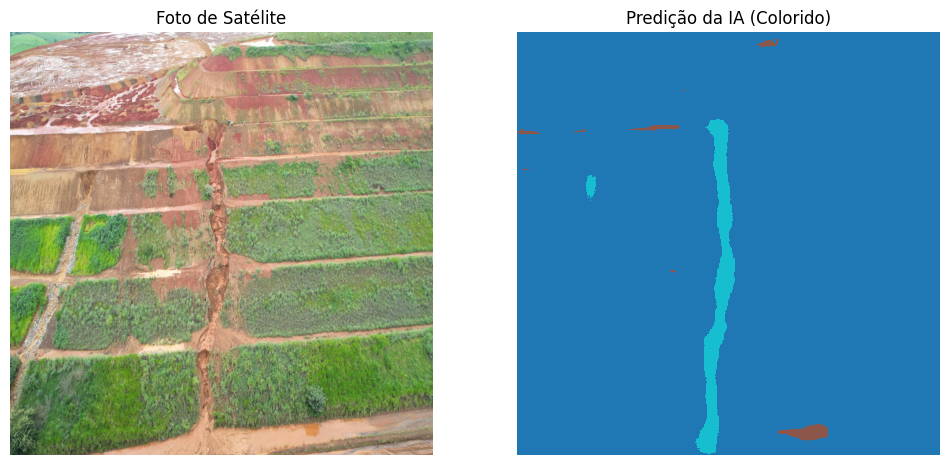

In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# --- 1. Definições (Se der erro de atributo, descomente isso) ---
# def pixel_accuracy(inp, targ):
#     targ = targ.squeeze(1) 
#     return (inp.argmax(dim=1) == targ).float().mean()

# --- 2. Carregar Modelo ---
# Se o arquivo estiver na mesma pasta, basta o nome
path_modelo = Path('modelo_resnet34_final_512.pkl') # ou o caminho completo
learn_inf = load_learner(path_modelo, cpu=True)

# --- 3. Escolher Imagem ---
path_dados = Path(r'/home/tempestade/Área de Trabalho/git/geoeyeai/cell_data')
arquivos = get_image_files(path_dados/'trainn')

if len(arquivos) > 0:
    # random.choice é mais seguro que randint (evita pegar indice que não existe)
    img_path = np.random.choice(arquivos)
    print(f"✅ Imagem sorteada: {img_path.name}")
    
    # --- 4. Predict ---
    img_path = "/home/tempestade/Área de Trabalho/git/geoeyeai/cell_data/trainn/agua_5_JPG.rf.0e54e5448c3b11767246a930f92023b7.jpg"
    img_path = "/home/tempestade/Área de Trabalho/git/geoeyeai/cell_data/trainn/trinca_311_jpg.rf.f9cf9d3867e25234860ddbb904c2392e.jpg"
    img_path = "/home/tempestade/Área de Trabalho/git/geoeyeai/cell_data/trainn/erosao_71_JPG.rf.a5fe06627840c572f85431cf9c288682.jpg"
    pred_mask, pred_idx, probs = learn_inf.predict(img_path)

    # --- 5. Visualização Melhorada ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Imagem Original
    img = PILImage.create(img_path)
    img.show(ctx=ax1, title='Foto de Satélite')

    # Máscara Predita (Com cores forçadas para ver melhor)
    # vmin=0, vmax=2 garante que o matplot saiba que só tem 3 classes
    # cmap='tab10' usa cores bem distintas (azul, laranja, verde...)
    ax2.imshow(pred_mask, vmin=0, vmax=2, cmap='tab10', interpolation='nearest')
    ax2.set_title('Predição da IA (Colorido)')
    ax2.axis('off')

    plt.show()

else:
    print("❌ Nenhuma imagem encontrada na pasta 'trainn'. Verifique o caminho!")